In [132]:
# SVM WITH MERGED DATA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
%matplotlib inline

df = pd.read_csv('merged_data_NEWer.csv', sep=',', header=0)
df = df.drop('timestamp', axis=1)
df = df.drop('date', axis=1)
df.shape
# we have 2 discrete variables and 12 continuous variables
df.head()

,sequence_name,activity,chest_x-coordinate,chest_y-coordinate,chest_z-coordinate,belt_x-coordinate,belt_y-coordinate,belt_z-coordinate,ar_x-coordinate,ar_y-coordinate,ar_z-coordinate,al_x-coordinate,al_y-coordinate,al_z-coordinate
0,A01,walking,4.291954,1.781140,1.344495,4.359101,1.826456,0.968821,4.324462,2.07246,0.488065,4.062931,1.892434,0.507425
1,A01,walking,4.291954,1.781140,1.344495,4.359101,1.826456,0.968821,4.324462,2.07246,0.488065,4.071232,1.888289,0.493945
2,A01,walking,4.309984,1.777778,1.333371,4.359101,1.826456,0.968821,4.324462,2.07246,0.488065,4.079534,1.884144,0.480464
3,A01,walking,4.328015,1.774416,1.322246,4.362803,1.841832,0.918870,4.324462,2.07246,0.488065,4.087835,1.879999,0.466983
4,A01,walking,4.346046,1.771054,1.311121,4.366505,1.857208,0.868920,4.324462,2.07246,0.488065,4.055501,1.835890,0.477998


In [133]:
# check distribution of 'activity' column
# the counts describe how long the person was performing the activity for and helps 
# describe the data. It's not necessarilly a data imbalance
df['activity'].value_counts()

lying                                     54480
walking                                   32710
sitting                                   27244
standing up from lying                    18361
sitting on the ground                     11779
lying down                                 6168
on all fours                               5210
falling                                    2973
standing up from sitting on the ground     2848
sitting down                               1706
standing up from sitting                   1381
Name: activity, dtype: int64

In [134]:
# view the percentage distribution of 'activity' column
df['activity'].value_counts()/len(df)

lying                                     0.330462
walking                                   0.198411
sitting                                   0.165255
standing up from lying                    0.111373
sitting on the ground                     0.071449
lying down                                0.037414
on all fours                              0.031603
falling                                   0.018033
standing up from sitting on the ground    0.017275
sitting down                              0.010348
standing up from sitting                  0.008377
Name: activity, dtype: float64

In [135]:
# check for null values in data set
df.isnull().sum()

sequence_name         0
activity              0
chest_x-coordinate    0
chest_y-coordinate    0
chest_z-coordinate    0
belt_x-coordinate     0
belt_y-coordinate     0
belt_z-coordinate     0
ar_x-coordinate       0
ar_y-coordinate       0
ar_z-coordinate       0
al_x-coordinate       0
al_y-coordinate       0
al_z-coordinate       0
dtype: int64

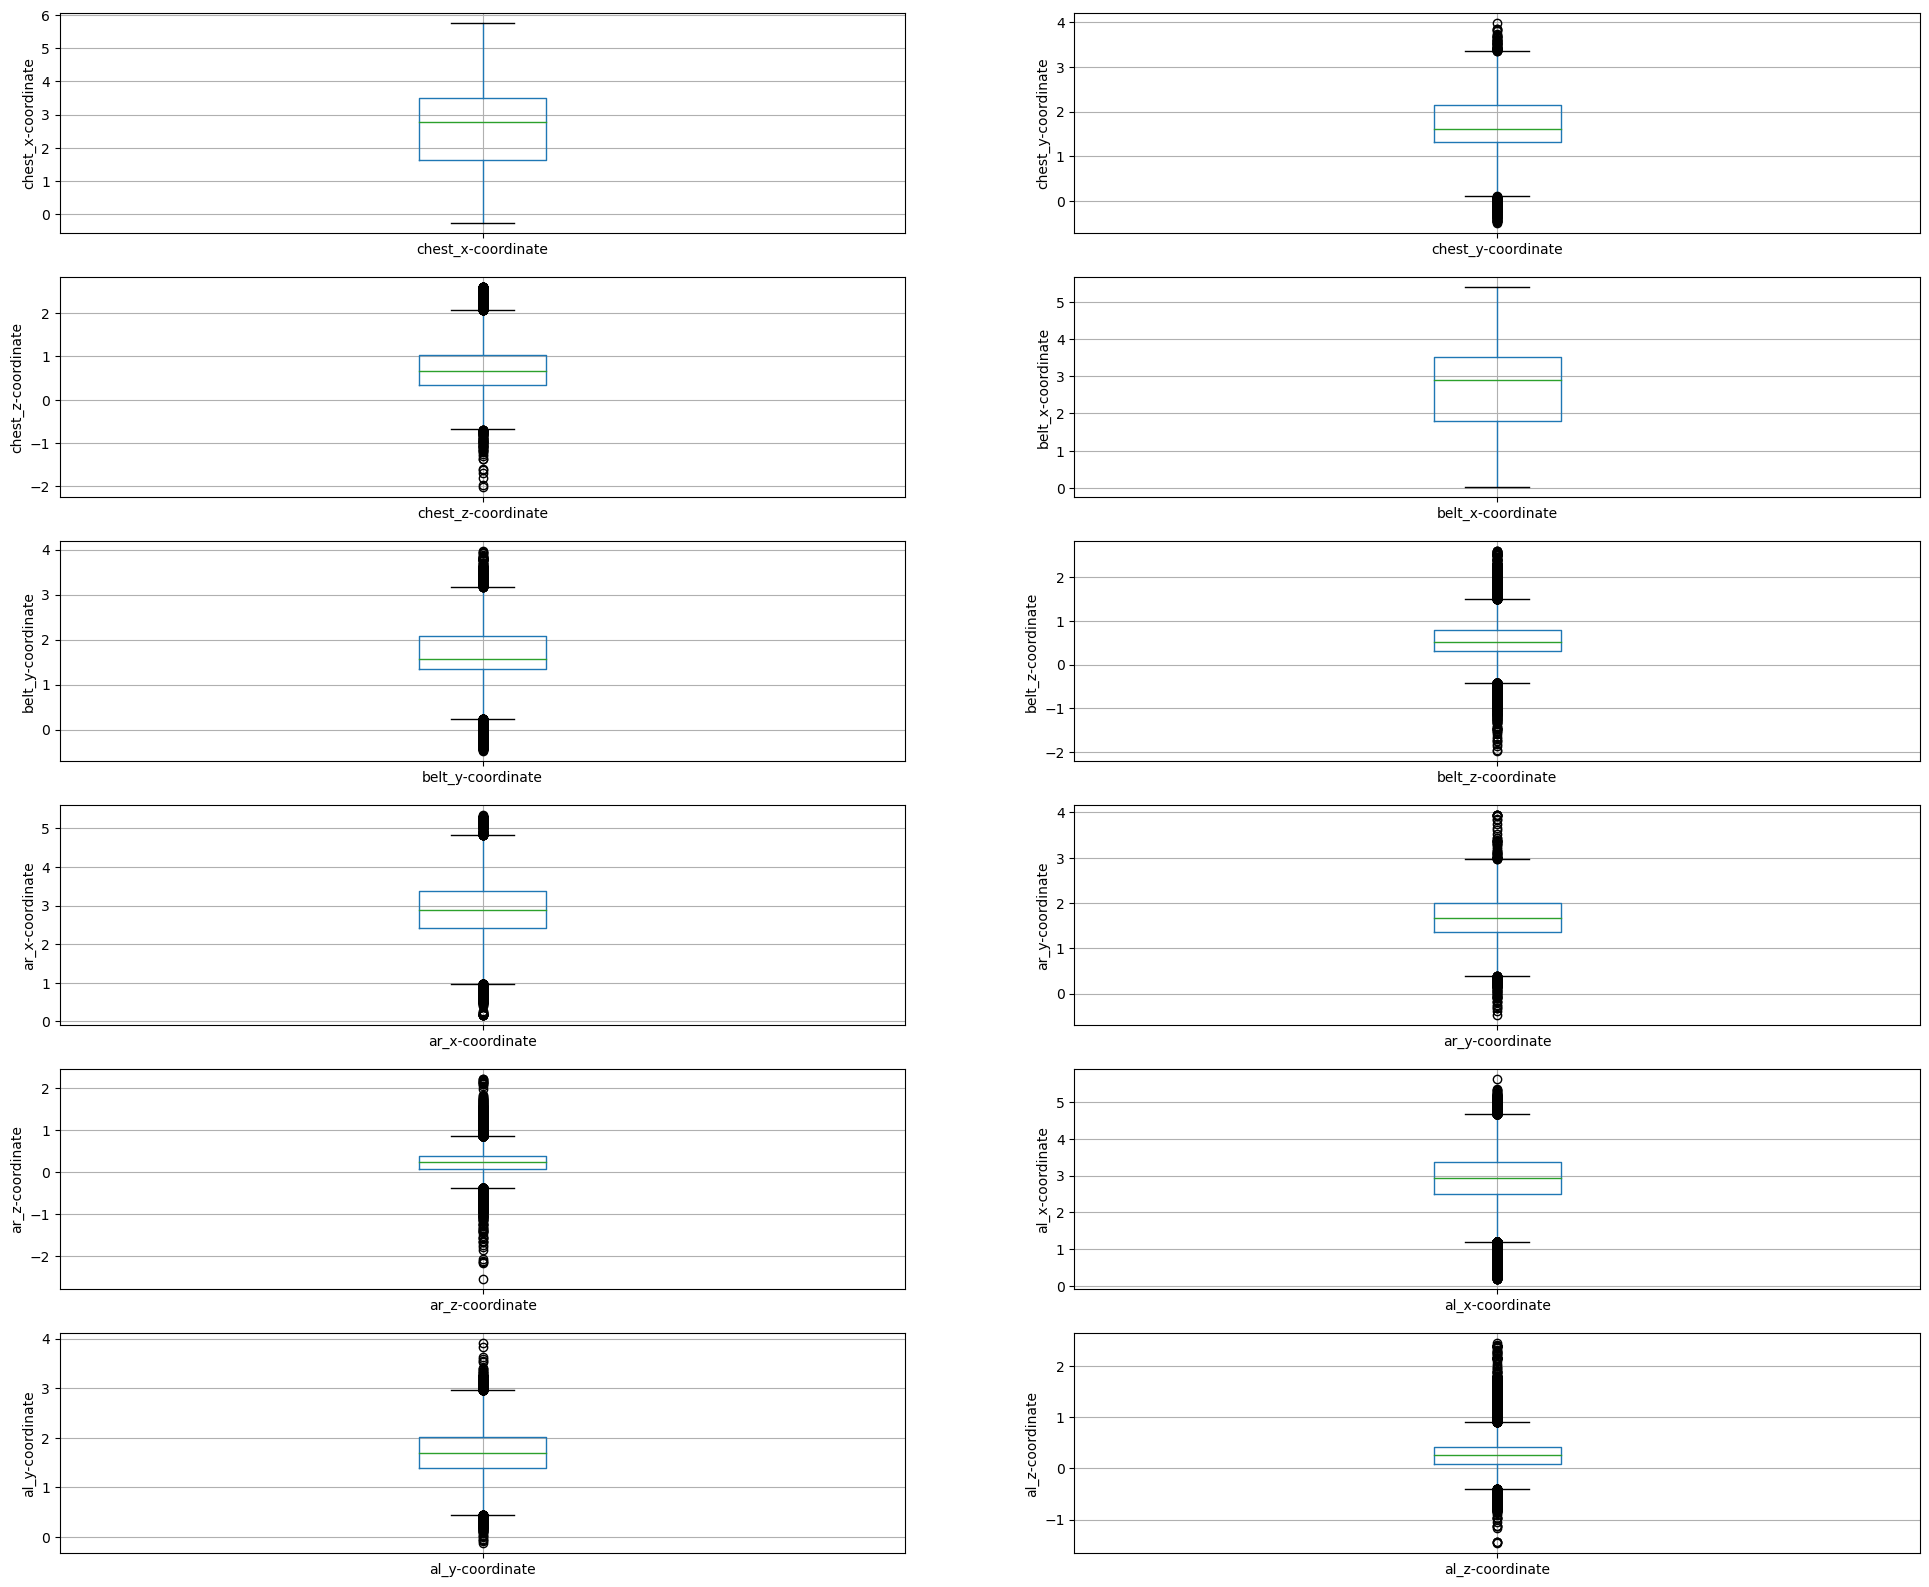

In [136]:
plt.figure(figsize=(24,20))

# box plots show lots of outliers
# but why are no data points showing up on some of the x coord box plots?
for i, column in enumerate(df):
    if (column != 'sequence_name') and (column != 'activity'):
        i -= 2
        plt.subplot(6, 2, 1+i)
        fig = df.boxplot(column=column)
        fig.set_title('')
        fig.set_ylabel(column)

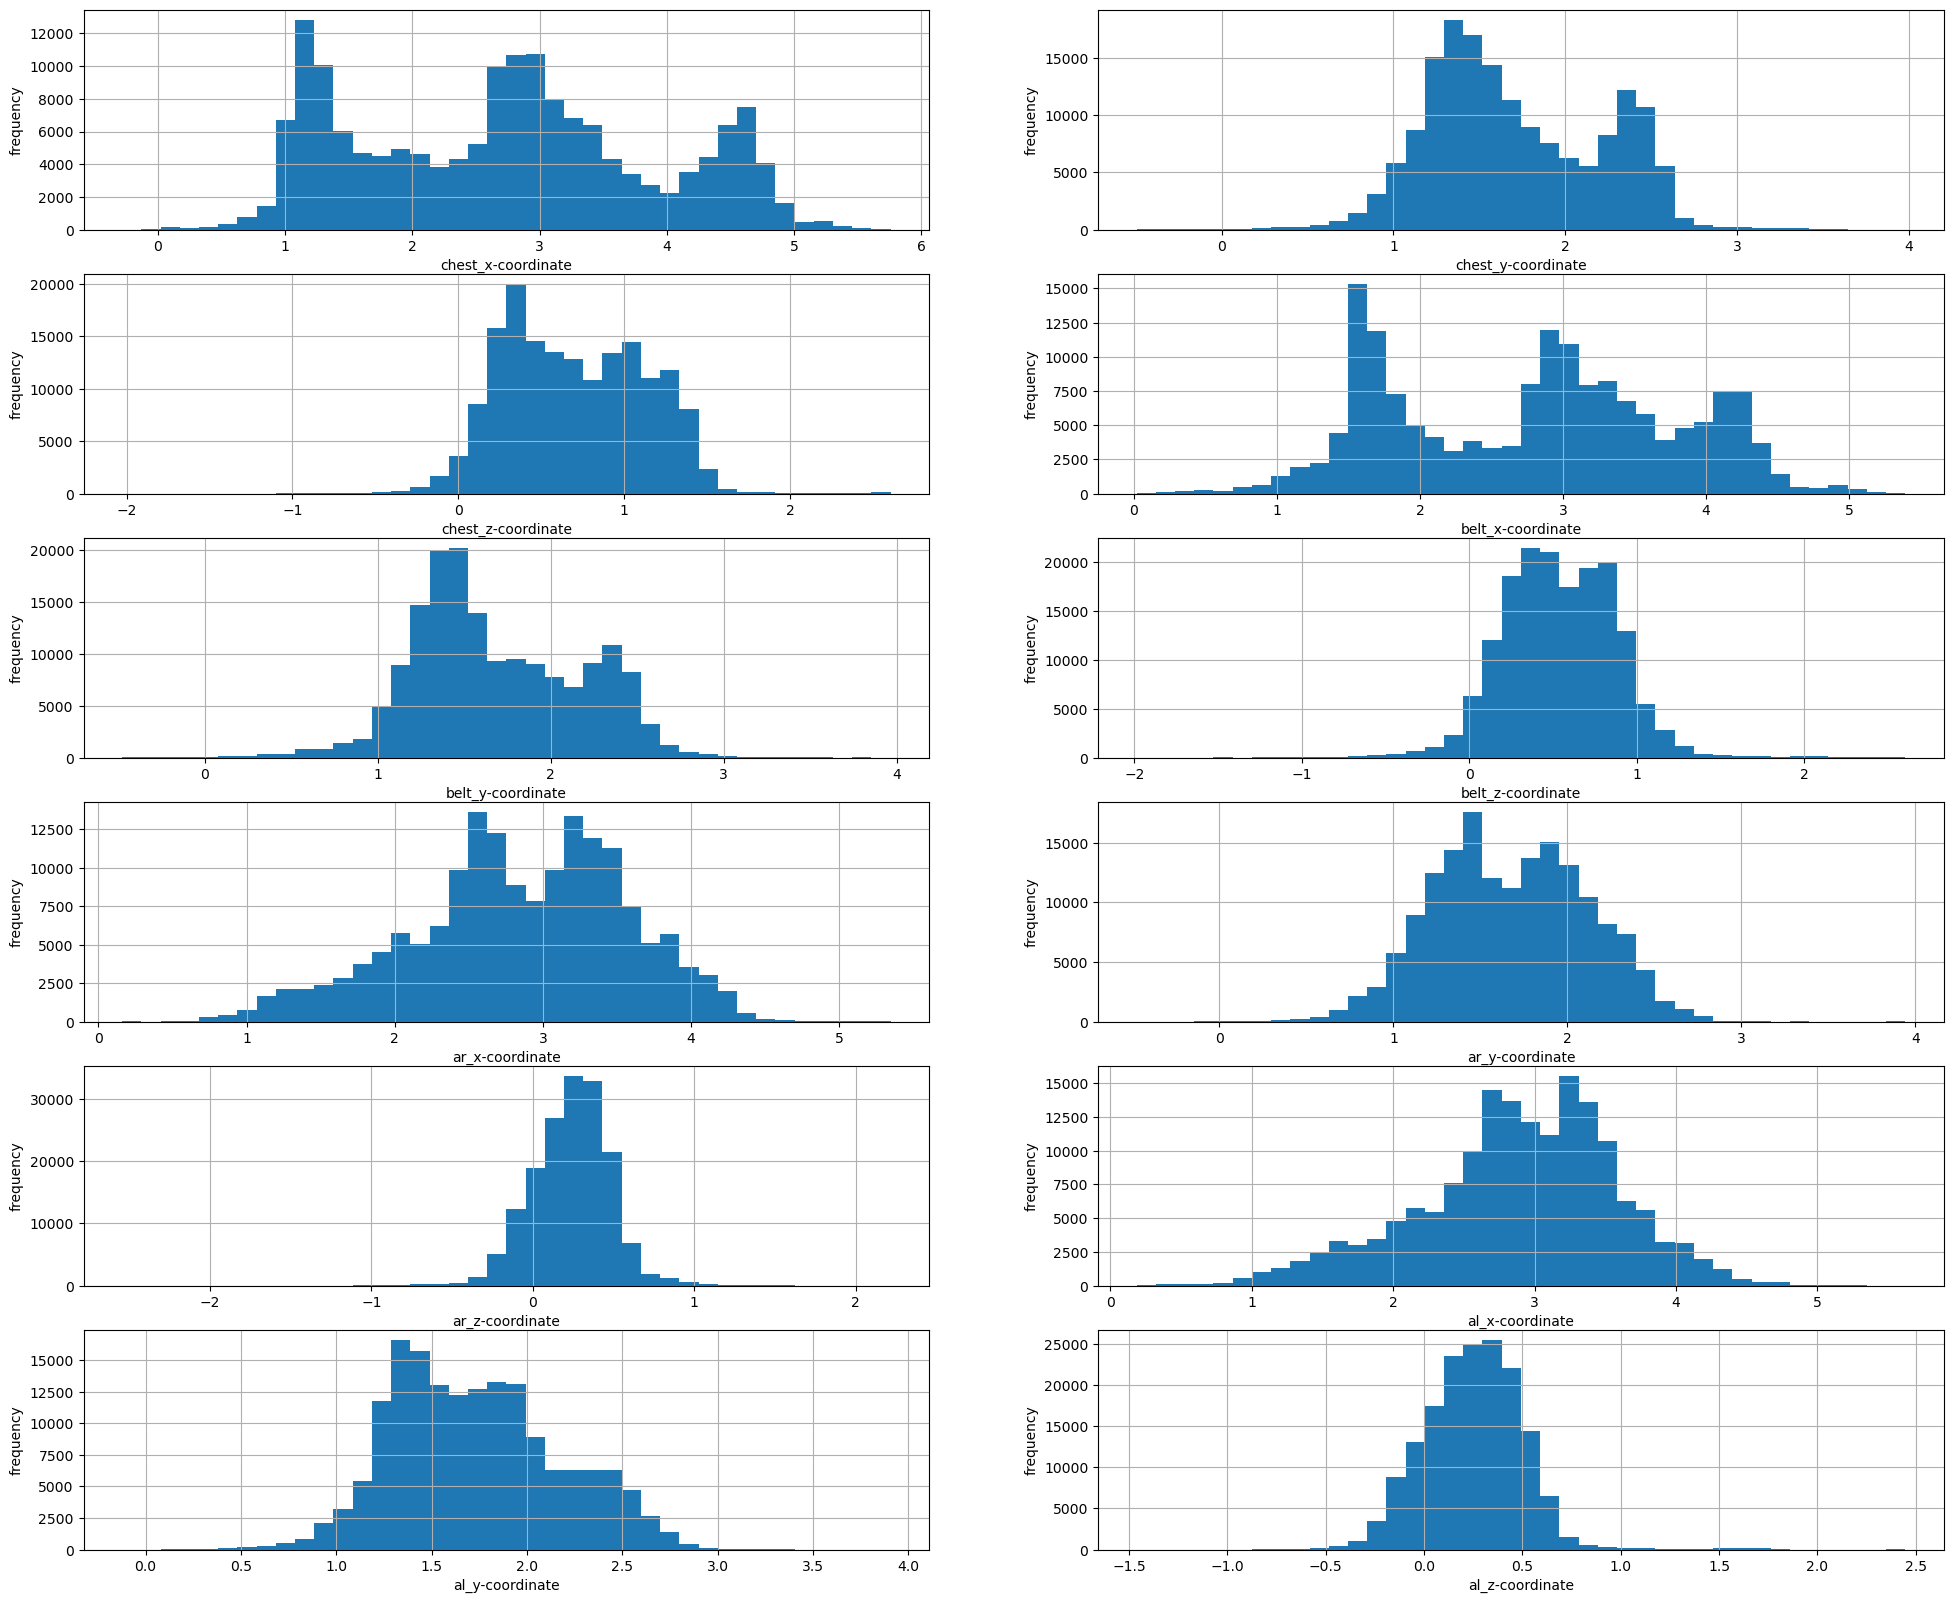

In [137]:
plt.figure(figsize=(24,20))

# distributions look quite good overall. Not much skewing.
for i, column in enumerate(df):
    if (column != 'sequence_name') and (column != 'activity'):
        i -= 2
        plt.subplot(6, 2, 1+i)
        fig = df[column].hist(bins=40)
        fig.set_title('')
        fig.set_xlabel(column)
        fig.set_ylabel('frequency')

# Encoding, Scaling and Training

In [138]:
# All A01-A05 sequences are selected (encoded 0-5). Roughly 20% of our data.
train_data = df[df['sequence_name'].isin(['A01', 'A02', 'A03', 'A04', 'A05'])]
test_data = df[df['sequence_name'].isin(['B01', 'B02', 'B03', 'B04', 'B05', 'C01',
                                         'C02', 'C03', 'C04', 'C05', 'D01', 'D02', 
                                         'D03', 'D04', 'D05', 'E01', 'E02', 'E03', 
                                         'E04', 'E05'])]

X_train = train_data.drop('sequence_name', axis = 1)
X_train = X_train.drop('activity', axis = 1)
y_train = train_data['activity'] 

X_test = test_data.drop('sequence_name', axis = 1)
X_test = X_test.drop('activity', axis = 1)
y_test = test_data['activity'] 

In [139]:
# feature scaling
cols = X_train.columns
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

X_train.describe()

,chest_x-coordinate,chest_y-coordinate,chest_z-coordinate,belt_x-coordinate,belt_y-coordinate,belt_z-coordinate,ar_x-coordinate,ar_y-coordinate,ar_z-coordinate,al_x-coordinate,al_y-coordinate,al_z-coordinate
count,2.747300e+04,2.747300e+04,2.747300e+04,2.747300e+04,2.747300e+04,2.747300e+04,2.747300e+04,2.747300e+04,2.747300e+04,2.747300e+04,2.747300e+04,2.747300e+04
mean,-4.138130e-17,4.138130e-17,8.483166e-17,2.482878e-17,-1.365583e-16,-1.603525e-16,1.738014e-16,-1.944921e-16,-1.986302e-16,1.820777e-16,-1.158676e-16,-1.944921e-16
std,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00
min,-2.478010e+00,-3.578487e+00,-5.719708e+00,-2.683096e+00,-3.815562e+00,-5.334488e+00,-3.599084e+00,-3.433081e+00,-5.200242e+00,-3.754310e+00,-3.609052e+00,-4.440271e+00
25%,-9.773368e-01,-7.950157e-01,-7.751224e-01,-9.899707e-01,-7.568710e-01,-4.717249e-01,-7.114931e-01,-7.423163e-01,-5.642141e-01,-7.391441e-01,-6.953948e-01,-6.930373e-01
50%,3.621181e-02,-2.535890e-01,-9.386708e-02,1.409570e-01,-2.830330e-01,-6.084311e-03,6.653482e-02,-2.540823e-01,9.983286e-02,2.010031e-01,-1.233366e-01,1.279275e-01
75%,6.040162e-01,8.908202e-01,8.488656e-01,7.727265e-01,8.917427e-01,5.770384e-01,7.545356e-01,7.593156e-01,5.949272e-01,6.514180e-01,5.768915e-01,7.113708e-01
max,2.467054e+00,4.060835e+00,5.012764e+00,2.096545e+00,4.066144e+00,6.161455e+00,2.439463e+00,2.901266e+00,5.695835e+00,3.057134e+00,3.571625e+00,8.568281e+00


In [22]:
# Set up a range of hyperparameters to test. 
# these are the parameter combinations that we want to test for the svc
param_grid = {'C': [1.0, 10.0, 100.0],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': ['auto', 'scale']}

# input all established arguments along with the model we want to test them with
# n_jobs=-1 requests to use all available cpu cores for the process
# uses k-fold by default
grid_search = GridSearchCV(SVC(), param_grid, n_jobs=-1)

# Fit the grid search object to the training data
# run the cross validation against the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

/opt/homebrew/Caskroom/miniforge/base/envs/kth-ml/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters:  {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
Best score:  0.7713098452240438


# Use Different Kernals

In [147]:
# use different kernals available with basic parameters to test accuracy scores
# rbf kernal and default paramaters 
svc=SVC(kernel = 'rbf', C = 1.0, gamma = 'auto') 
svc.fit(X_train,y_train)
y_pred_test=svc.predict(X_test)
print('Model accuracy score with rbf kernal and c=1.0: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score with rbf kernal and c=1.0: 0.6807


## Evaluate

In [148]:
# compare train set and test set against rbf, linear and polynomial kernals
y_pred_train = svc.predict(X_train)
print('Training-set accuracy score rbf: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score rbf: 0.9283


In [149]:
# check data for overfitting
print('Training set score: {:.4f}'.format(svc.score(X_train, y_train))),
print('Test set score: {:.4f}'.format(svc.score(X_test, y_test)))

Training set score: 0.9283
Test set score: 0.6807


## Evaluation

In [150]:
# Null accuracy 
# the accuracy that could be achieved by always picking the most frequent class

counts = y_test.value_counts()
null_accuracy = (counts.max() / counts.sum())

print('null accuracy: {:.4f}'.format(null_accuracy))

null accuracy: 0.3194


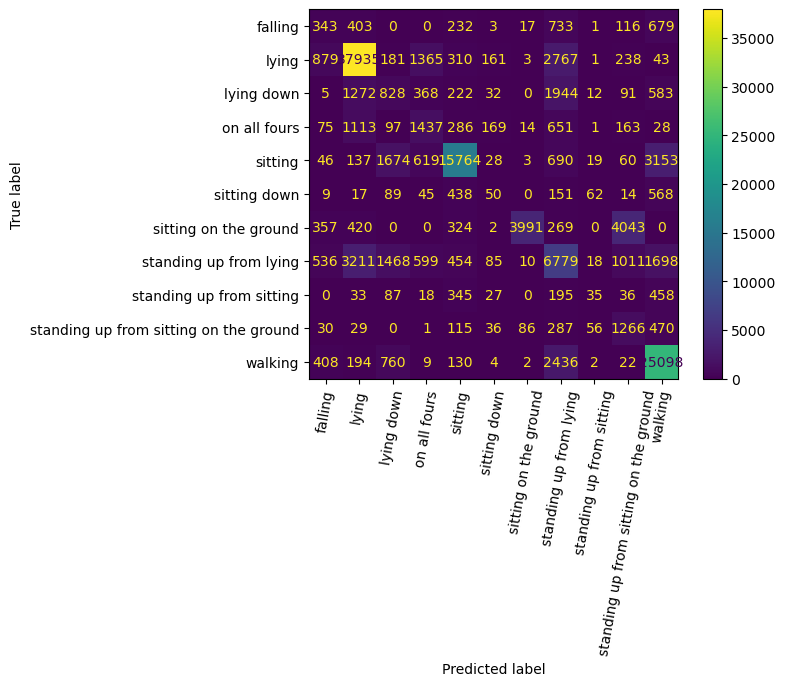


True Positives(TP) =  343

True Negatives(TN) =  37935

False Positives(FP) =  403

False Negatives(FN) =  879


In [151]:
# confusion matrix

cm = confusion_matrix(y_test, y_pred_test, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()
plt.xticks(rotation = 80)
plt.show()

print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

In [152]:
# classification report generation
print(classification_report(y_test, y_pred_test, zero_division = 1))

# classification accuracy
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

# classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error : {0:0.4f}'.format(classification_error))

# print precision score
# the percentage of correctly predicted positive outcomes out of 
# all the predicted positive outcomes.
precision = TP / float(TP + FP)
print('Precision (correctly predicted pos outcomes / all positive outcomes): {0:0.4f}'.format(precision))


                                        precision    recall  f1-score   support

                               falling       0.13      0.14      0.13      2527
                                 lying       0.85      0.86      0.86     43883
                            lying down       0.16      0.15      0.16      5357
                          on all fours       0.32      0.36      0.34      4034
                               sitting       0.85      0.71      0.77     22193
                          sitting down       0.08      0.03      0.05      1443
                 sitting on the ground       0.97      0.42      0.59      9406
                standing up from lying       0.40      0.43      0.41     15869
              standing up from sitting       0.17      0.03      0.05      1234
standing up from sitting on the ground       0.18      0.53      0.27      2376
                               walking       0.77      0.86      0.81     29065

                              accuracy